In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import multivariate_normal, permutation
import pandas as pd
from pandas import DataFrame, Series

np.random.seed(20160614)
tf.set_random_seed(20160614)

/Users/admin/.pyenv/versions/anaconda3-2.4.0/envs/tensorFlow/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
def generate_detablock(n, mu, var, t):
    data = multivariate_normal(mu, np.eye(2)*var, n)
    df = DataFrame(data, columns=['x1', 'x2'])
    df['t'] = t
    return df

df0 = generate_detablock(15,[7,7],22,0)
df1 = generate_detablock(15,[22,7],22,0)
df2 = generate_detablock(15,[7,22],22,0)
df3 = generate_detablock(15,[20,20],22,1)

df = pd.concat([df0, df1, df2, df3], ignore_index=True)
train_set = df.reindex(permutation(df.index)).reset_index(drop=True)


In [3]:
train_x = train_set[['x1','x2']].as_matrix()
train_t = train_set['t'].as_matrix().reshape([len(train_set),1])

In [4]:
num_units = 2
mult = train_x.flatten().mean()

x = tf.placeholder(tf.float32, [None, 2])

w1 = tf.Variable(tf.truncated_normal([2, num_units]))
b1 = tf.Variable(tf.zeros([num_units]))
hidden1 = tf.nn.tanh(tf.matmul(x, w1) + b1 * mult)

w0 = tf.Variable(tf.zeros([num_units, 1]))
b0 = tf.Variable(tf.zeros([1]))
p = tf.nn.sigmoid(tf.matmul(hidden1, w0) + b0*mult)

In [5]:
t = tf.placeholder(tf.float32, [None,1])
loss = -tf.reduce_sum(t*tf.log(p) + (1-t)*tf.log(1-p))
train_step = tf.train.GradientDescentOptimizer(0.001).minimize(loss)
correct_prediction = tf.equal(tf.sign(p-0.5), tf.sign(t-0.5))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [6]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [7]:
i = 0
for _ in range(1000):
    i += 1
    sess.run(train_step, feed_dict={x:train_x, t:train_t})
    if i % 100 == 0:
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={x:train_x, t:train_t})
        print('step: %d, loss: %f, accuracy: %f' % (i, loss_val, acc_val))

step: 100, loss: 38.520889, accuracy: 0.750000
step: 200, loss: 38.356873, accuracy: 0.750000
step: 300, loss: 34.917309, accuracy: 0.650000
step: 400, loss: 30.122335, accuracy: 0.750000
step: 500, loss: 25.487167, accuracy: 0.750000
step: 600, loss: 24.755581, accuracy: 0.750000
step: 700, loss: 24.754236, accuracy: 0.766667
step: 800, loss: 23.264198, accuracy: 0.750000
step: 900, loss: 26.504963, accuracy: 0.783333
step: 1000, loss: 15.408275, accuracy: 0.933333


In [10]:
train_set0 = train_set[train_set['t'] == 0]
train_set1 = train_set[train_set['t'] == 1]

fig = plt.figure(figsize=(6,6))
subplot = fig.add_subplot(1,1,1)
subplot.set_ylim([0,30])
subplot.set_xlim([0,30])
subplot.scatter(train_set1.x1,train_set1.x2, marker='x')
subplot.scatter(train_set0.x1,train_set0.x2, marker='o')

locations = [] 
for x2 in np.linspace(0, 30, 100):
    for x1 in np.linspace(0,30,100):
        locations.append((x1,x2))
p_vals = sess.run(p, feed_dict={x:locations})
p_vals = p_vals.reshape((100,100))
subplot.imshow(p_vals, origin='lower', extent=(0, 30, 0, 30), cmap=plt.cm.gray_r, alpha=0.5)

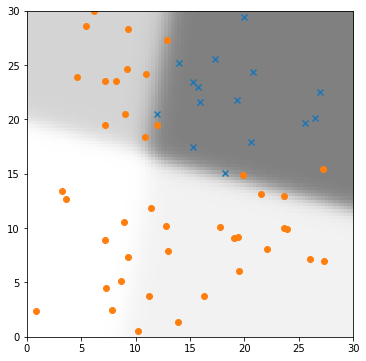

In [11]:
fig